In [3]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest, ExtraSurvivalTrees
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
import numpy as np
import pandas as pd

def compare_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    # Initialize the GBST survival regressor
    gbst = GradientBoostingSurvivalAnalysis(n_estimators=100, random_state=20)
    # Fit the model to the training data
    gbst.fit(X_train, y_train)
    # Predict the survival times for the testing data
    survival_times_gbst = gbst.predict(X_test)

    # Create an instance of the RandomSurvivalForest model
    rsf = RandomSurvivalForest(n_estimators=100, random_state=20, n_jobs=-1)
    # Fit the model on the training data
    rsf.fit(X_train, y_train)
    # Predict the survival times for the testing data
    survival_times_rsf = rsf.predict(X_test)

    est = ExtraSurvivalTrees(n_estimators=100, random_state=20, n_jobs=-1)
    est.fit(X_train, y_train)
    survival_times_est = est.predict(X_test)

    # Prepare the target variable for CoxPHSurvivalAnalysis
    y_coxph = np.array(list(zip(y_train['event'], y_train['time'])), dtype=[('event', bool), ('time', float)])

    # Create an instance of the CoxPHSurvivalAnalysis model with regularization
    coxph = CoxPHSurvivalAnalysis(alpha=1e-9)
    # Fit the model on the training data
    coxph.fit(X_train, y_coxph)
    # Predict the survival times for the testing data
    survival_times_coxph = coxph.predict(X_test)

    # Compute the concordance index to evaluate the model performance
    c_index_gradient = concordance_index(y_test['time'], -survival_times_gbst, y_test['event'])
    c_index_rf = concordance_index(y_test['time'], -survival_times_rsf, y_test['event'])
    c_index_coxph = concordance_index(y_test['time'], -survival_times_coxph, y_test['event'])
    c_index_est = concordance_index(y_test['time'], -survival_times_est, y_test['event'])

    return {
        "gradient": c_index_gradient,
        "random_survival": c_index_rf,
        "coxph": c_index_coxph,
        "est": c_index_est
}


In [36]:

data = pd.read_csv('IFR_Extract_with_selected_columns_15-5-23.csv')

obreak_date = pd.to_datetime(data.obreak_date)
datebone = pd.to_datetime(data.datebone)
y = ( abs( datebone - obreak_date))
X = data.drop(["obreak_date","datebone"],axis=1)
selectedColumns = [ 'PatientAge', "PatientGender",'parentbreak', 'alcohol',
                'arthritis', 'diabetes',
                'oralster', 'smoke', 'obreak','ptunsteady','obreak_hip','marital','whereliv','ptfall','obreak_frac_count','specialistReferral','fpp_info','obreak_spine','obreak_pelvis']
dropList = []
for i in data:
    if data[i].dtypes == 'O':
        dropList.append(data[i].name)
dropList.append("CompletedSurveyId")
dropList.append("PatientId")
X = data.drop(dropList,axis=1)
X.fillna(0,inplace=True)
y = pd.DataFrame({"time":y})

y['event'] = y.time.apply(lambda x: x.days != 0 )
structured_array = y.to_records(index=False)

swapped = pd.DataFrame({
    "event": y.event,
    "time": y.time.apply(lambda x: x.days)
})
(swapped.event).value_counts()
swapped.event = swapped.event.astype(bool)
structured_array = np.rec.array(swapped.to_records(index=False))

mergedBeforeEncoding = pd.concat([X[selectedColumns],swapped],axis=1)
mergedBeforeEncoding
(data['fpp_info']).value_counts()

1    267
3    209
4    205
5    111
2      8
Name: fpp_info, dtype: int64

In [5]:
import random
# Define the number of synthetic samples
num_samples = 0

# Get the column types for each column in mergedBeforeEncoding
column_types = {}
for column in mergedBeforeEncoding.columns:
    column_types[column] = mergedBeforeEncoding[column].dtype

# Shuffle the feature names
feature_names = list(mergedBeforeEncoding.columns)
random.shuffle(feature_names)

# Initialize an empty DataFrame to store the selected features and their performance
selected_features = pd.DataFrame(columns=["Feature"])

# Create a synthetic data DataFrame with the same columns as mergedBeforeEncoding
synthetic_data = pd.DataFrame(columns=mergedBeforeEncoding.columns)

# Generate synthetic data for each feature
for feature in feature_names:
    column_type = column_types[feature]

    if column_type == bool:
        synthetic_data[feature] = np.random.choice([False, True], size=num_samples)
    else:
        # Sample values from the existing data to maintain the distribution
        existing_data_values = mergedBeforeEncoding[feature].dropna().values
        synthetic_data[feature] = np.random.choice(existing_data_values, size=num_samples)

    synthetic_data[feature] = synthetic_data[feature].astype(column_type)

# Add additional columns to the synthetic data
synthetic_data["obreak"] = 1
synthetic_data["event"] = False
synthetic_data["time"] = 0

augmented_data = pd.concat([mergedBeforeEncoding, synthetic_data], ignore_index=True)



# Store the selected features
selected_features["Feature"] = feature_names

cat_features = ['parentbreak', 'alcohol',
                'oralster', 'smoke','ptunsteady','marital','whereliv','ptfall','obreak_frac_count','specialistReferral','fpp_info','obreak_spine','obreak_pelvis'
                # These features were determined to apply minimal impact even
                # 'respdisease', 'hbp','heartdisease',
                # 'ptunsteady', 'wasfractdue2fall', 'cholesterol',
                # 'ptfall', 'shoulder', 'wrist', 'bmdtest_10yr_caroc'
                ]

for feature in cat_features:
    if augmented_data is not None:
        if feature in augmented_data.columns:
            cat_one_hot = pd.get_dummies(augmented_data[feature], prefix=f'{feature}', drop_first=False)
            augmented_data = augmented_data.drop(feature, axis=1)
            augmented_data = augmented_data.join(cat_one_hot)
augmented_data = augmented_data.loc[augmented_data['time'] > -1]            
X = augmented_data.drop(['event','time'],axis=1)
y = augmented_data[['event','time']]

y = np.rec.array(y.to_records(index=False))
data['marital'].value_counts()

2.0    343
6.0    218
1.0     81
5.0     60
8.0     20
3.0     17
4.0     11
7.0      8
Name: marital, dtype: int64

In [6]:
import itertools

feature_comparisons = {
    'gradient': {
        'value': 0,
        'features': []
    },
    'random_survival': {
        'value': 0,
        'features': []
    },
    'coxph': {
        'value': 0,
        'features': []
    },
    'est':{
        'value':0,
        'features':[                                    ]
    }
}

models = list(feature_comparisons.keys())

def explore_feature_combinations(X, y, max_iterations=8000):
    best_features = []
    best_performance = 0
    best_model_name = ""

    current_features = set()
    remaining_features = set(X.columns)  # Initialize remaining_features with all column names of X

    while remaining_features:
        performance_gain = False
        best_gain = 0
        best_feature = None

        for feature in remaining_features:
            features_to_try = current_features | {feature}
            X_subset = X[list(features_to_try)]
            outcome = compare_models(X_subset, y)

            for model_name in models:
                if outcome[model_name] > best_performance:
                    gain = outcome[model_name] - best_performance
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature
                        best_model_name = model_name

        if best_feature is not None:
            current_features.add(best_feature)
            remaining_features.remove(best_feature)
            best_performance += best_gain
            performance_gain = True
            for model in models:
                if feature_comparisons[model]['value'] < outcome[model]:
                    feature_comparisons[model]['features'] = list(features_to_try)
                    feature_comparisons[model]['value'] = outcome[model]

        if not performance_gain or len(current_features) >= max_iterations:
            break

    return best_model_name, list(current_features), best_performance

# Call the function with a maximum of iterations equal to the total number of features
best_model_name, best_features, best_performance = explore_feature_combinations(X, y, max_iterations=len(X.columns))

print("Best feature combination:", best_features)
print("Highest C-index:", best_performance)
print("Best Model:", best_model_name)
for model, comparison in feature_comparisons.items():
    print(model, comparison)


Best feature combination: ['whereliv_6.0', 'ptfall_1', 'ptunsteady_2', 'specialistReferral_2', 'whereliv_1.0', 'whereliv_2.0', 'fpp_info_3']
Highest C-index: 0.6670240310704749
Best Model: coxph
gradient {'value': 0.6554939720042074, 'features': ['whereliv_1.0', 'ptfall_1', 'fpp_info_3', 'obreak_spine_0.0']}
random_survival {'value': 0.6556962537422122, 'features': ['whereliv_1.0', 'ptfall_1', 'fpp_info_3', 'obreak_spine_0.0']}
coxph {'value': 0.6548264422687919, 'features': ['whereliv_1.0', 'ptfall_1', 'fpp_info_3', 'obreak_spine_0.0']}
est {'value': 0.6565862933894328, 'features': ['whereliv_1.0', 'ptfall_1', 'fpp_info_3', 'obreak_spine_0.0']}


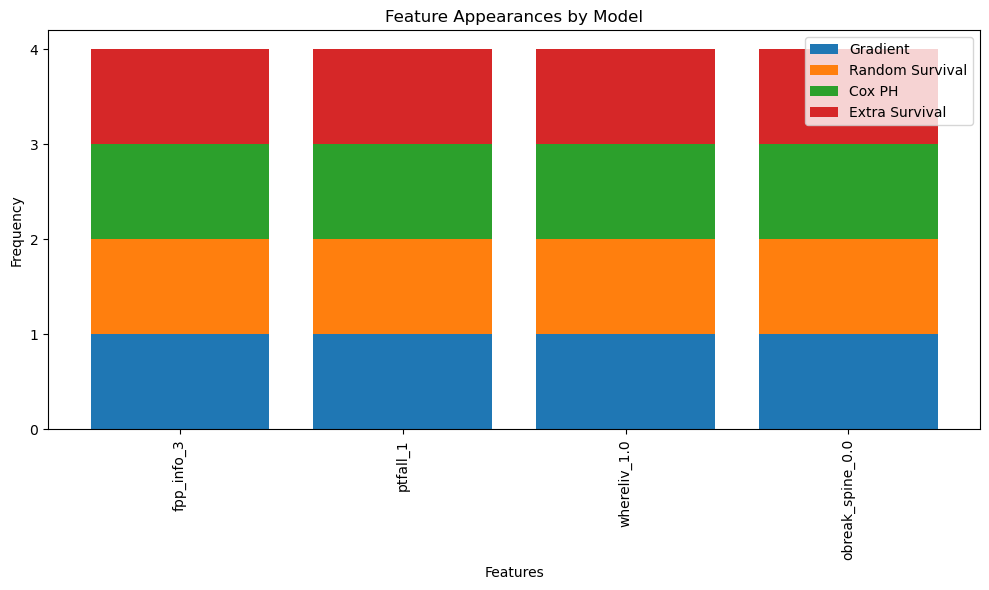

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the features for each model stored in feature_comparisons
model1_features = feature_comparisons['gradient']['features']
model2_features = feature_comparisons['random_survival']['features']
model3_features = feature_comparisons['coxph']['features']
model4_features = feature_comparisons['est']['features']

# Combine all the features from all the models
all_features = list(set(model1_features + model2_features + model3_features + model4_features))

# Count the occurrences of each feature in each model
model_features = [model1_features, model2_features, model3_features, model4_features]
feature_counts = np.zeros((len(all_features), len(model_features)), dtype=int)

for i, feature in enumerate(all_features):
    for j, model_feature in enumerate(model_features):
        if feature in model_feature:
            feature_counts[i, j] = 1

# Calculate the frequency of appearance for each feature
feature_frequency = np.sum(feature_counts, axis=1)

# Create stacked bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(all_features)), feature_counts[:, 0], label='Gradient', color='tab:blue')
plt.bar(range(len(all_features)), feature_counts[:, 1], label='Random Survival', color='tab:orange', bottom=feature_counts[:, 0])
plt.bar(range(len(all_features)), feature_counts[:, 2], label='Cox PH', color='tab:green', bottom=np.sum(feature_counts[:, :2], axis=1))
plt.bar(range(len(all_features)), feature_counts[:, 3], label='Extra Survival', color='tab:red', bottom=np.sum(feature_counts[:, :3], axis=1))

# Customize the chart
plt.xlabel('Features')
plt.ylabel('Frequency')
plt.title('Feature Appearances by Model')
plt.xticks(range(len(all_features)), all_features, rotation=90)
plt.legend()

# Set the y-axis tick labels to integers
plt.gca().get_yaxis().set_major_locator(plt.MaxNLocator(integer=True))

# Adjust layout and spacing
plt.tight_layout()

# Display the chart
plt.show()


In [14]:
X.columns

Index(['PatientAge', 'PatientGender', 'arthritis', 'diabetes', 'obreak',
       'obreak_hip', 'parentbreak_0', 'parentbreak_1', 'parentbreak_2',
       'parentbreak_4', 'alcohol_0', 'alcohol_1', 'alcohol_2', 'alcohol_3',
       'alcohol_4', 'oralster_0', 'oralster_1', 'oralster_2', 'oralster_4',
       'smoke_0', 'smoke_1', 'smoke_3', 'smoke_4', 'ptunsteady_0',
       'ptunsteady_1', 'ptunsteady_2', 'ptunsteady_4', 'marital_0.0',
       'marital_1.0', 'marital_2.0', 'marital_3.0', 'marital_4.0',
       'marital_5.0', 'marital_6.0', 'marital_7.0', 'marital_8.0',
       'whereliv_0.0', 'whereliv_1.0', 'whereliv_2.0', 'whereliv_3.0',
       'whereliv_4.0', 'whereliv_6.0', 'whereliv_7.0', 'ptfall_0', 'ptfall_1',
       'ptfall_2', 'ptfall_4', 'obreak_frac_count_0.0',
       'obreak_frac_count_1.0', 'obreak_frac_count_2.0',
       'obreak_frac_count_3.0', 'specialistReferral_2', 'specialistReferral_3',
       'specialistReferral_4', 'specialistReferral_5', 'specialistReferral_6',
       'sp

In [8]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Prepare the target variable for CoxnetSurvivalAnalysis
y_coxnet = np.array(list(zip(y_train['event'], y_train['time'])), dtype=[('event', bool), ('time', float)])

# Create an instance of the CoxnetSurvivalAnalysis model
coxnet = CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.5, n_alphas=100)

# Fit the model on the training data
coxnet.fit(X_train, y_coxnet)

# Predict the survival times for the testing data
survival_times_coxnet = coxnet.predict(X_test)

# Compute the concordance index to evaluate the model performance
c_index_coxnet = concordance_index(y_test['time'], -survival_times_coxnet, y_test['event'])

print("Coxnet C-index:", c_index_coxnet)



Coxnet C-index: 0.5988146290152925


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.util import Surv
from sklearn.model_selection import train_test_split

# # Select the subset of features from X
# selected_features = ['whereliv_1.0', 'ptfall_1', 'fpp_info_3', 'whereliv_2.0', 'fpp_info_2', 'fxworried_3.0', 'rsrch_data_use_0.0', 'specialistReferral_2']

X_subset = X[best_features]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)
# Convert y_train to a pandas DataFrame
y_train_df = pd.DataFrame.from_records(y_train, columns=["time", "event"])
if best_model_name == 'coxph':
    # Fit the CoxPHSurvivalAnalysis model on the training data
    coxph = CoxPHSurvivalAnalysis()
    coxph.fit(X_train, Surv.from_dataframe(event="event", time="time", data=y_train_df))
    # Predict the survival curves for the training data
    predicted_survival = coxph.predict_survival_function(X_train)
elif best_model_name == 'gradient':
    gradient = GradientBoostingSurvivalAnalysis()
    gradient.fit(X_train,Surv.from_dataframe(event="event", time="time", data=y_train_df))
    predicted_survival = gradient.predict_survival_function(X_train)
elif best_model_name == 'random_survival':
    rsf = RandomSurvivalForest()
    rsf.fit(X_train,Surv.from_dataframe(event="event", time="time", data=y_train_df))
    predicted_survival = rsf.predict_survival_function(X_train)








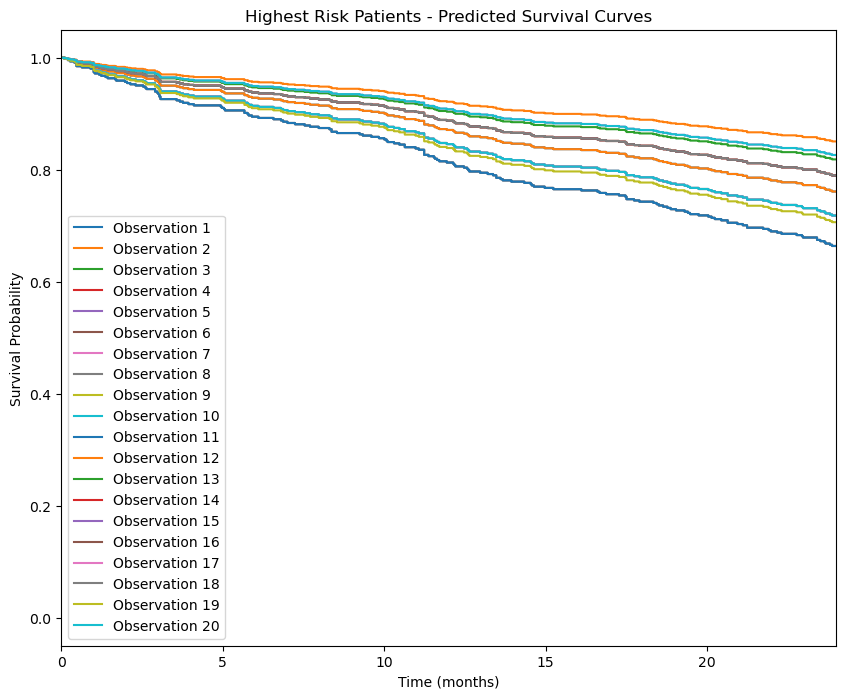

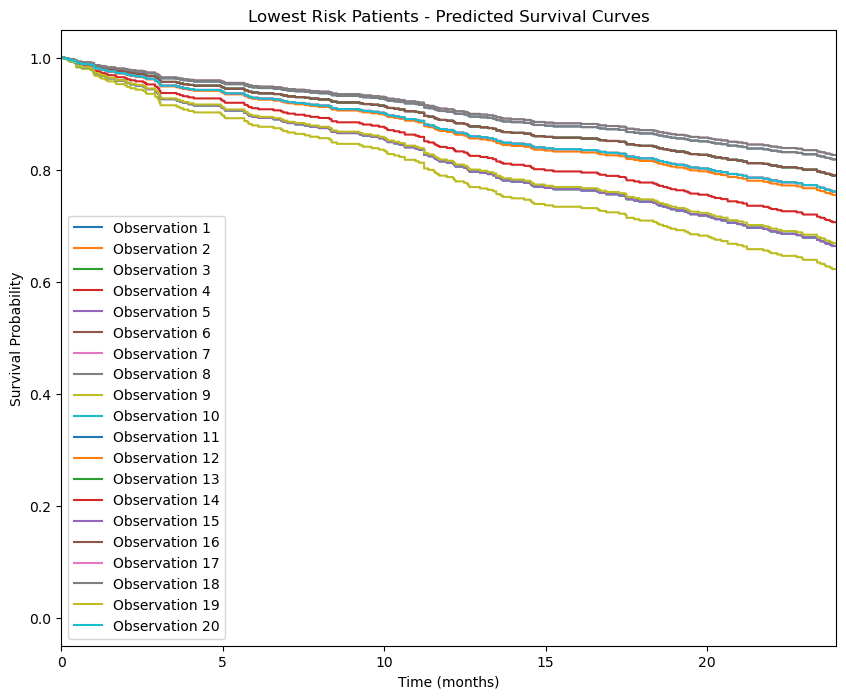

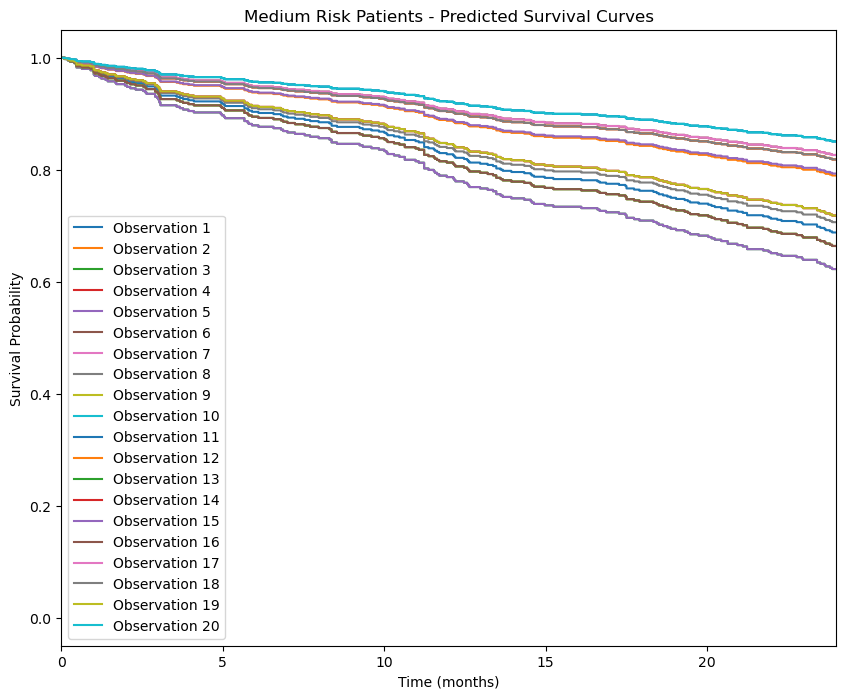

In [10]:
# Sort the predicted survival curves based on risk scores
sorted_curves = sorted(predicted_survival, key=lambda sf: sf.y[0], reverse=True)

# Select survival curves for highest, lowest, and medium risk patients
lowest_risk_curves = sorted_curves[:20]
highest_risk_curves = sorted_curves[-20:]
medium_risk_curves = sorted_curves[len(sorted_curves)//2 : len(sorted_curves)//2 + 20]

# Plot the survival curves for the highest risk patients
plt.figure(figsize=(10, 8))
for i, sf in enumerate(highest_risk_curves):
    plt.step(sf.x / 30, sf.y, where="post", label=f"Observation {i+1}")

plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.title(f'Highest Risk Patients - Predicted Survival Curves')
plt.legend()
plt.xlim(0, 24)
plt.show()

# Plot the survival curves for the lowest risk patients
plt.figure(figsize=(10, 8))
for i, sf in enumerate(lowest_risk_curves):
    plt.step(sf.x / 30, sf.y, where="post", label=f"Observation {i+1}")

plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.title(f'Lowest Risk Patients - Predicted Survival Curves')
plt.legend()
plt.xlim(0, 24)
plt.show()

# Plot the survival curves for the medium risk patients
plt.figure(figsize=(10, 8))
for i, sf in enumerate(medium_risk_curves):
    plt.step(sf.x / 30, sf.y, where="post", label=f"Observation {i+1}")

plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.title(f'Medium Risk Patients - Predicted Survival Curves')
plt.legend()
plt.xlim(0, 24)
plt.show()




In [11]:
from sksurv.nonparametric import kaplan_meier_estimator
from lifelines.utils import concordance_index

# Fit the Kaplan-Meier estimator
time, survival_probs = kaplan_meier_estimator(y['event'], y['time'])

# Get the survival probabilities for each individual data point
individual_survival_probs = survival_probs[np.searchsorted(time, y['time'])]

# Calculate the c-index
c_index = concordance_index(y['time'], -individual_survival_probs, y['event'])
print("Concordance Index:", c_index)
print(survival_probs)


Concordance Index: 1.0
[1.         0.99873737 0.99747475 0.99621212 0.99494949 0.99368687
 0.98989899 0.98863636 0.98737374 0.98358586 0.98232323 0.98106061
 0.97979798 0.97853535 0.97727273 0.9760101  0.97474747 0.97222222
 0.9709596  0.96843434 0.96717172 0.96590909 0.96464646 0.96338384
 0.96212121 0.96085859 0.95833333 0.95707071 0.95580808 0.95328283
 0.94949495 0.94823232 0.94570707 0.94444444 0.94318182 0.94191919
 0.94065657 0.93939394 0.93813131 0.93686869 0.93560606 0.93308081
 0.93181818 0.93055556 0.92929293 0.92676768 0.92550505 0.92424242
 0.9229798  0.92171717 0.92045455 0.91919192 0.91792929 0.91666667
 0.91540404 0.91414141 0.91287879 0.91161616 0.91035354 0.90909091
 0.90656566 0.90530303 0.9040404  0.90277778 0.90025253 0.8989899
 0.89772727 0.89646465 0.89520202 0.89393939 0.89267677 0.89141414
 0.89015152 0.88762626 0.88636364 0.88510101 0.88005051 0.87878788
 0.87752525 0.87626263 0.875      0.87247475 0.87121212 0.86868687
 0.86742424 0.86489899 0.86363636 0.8623

In [12]:
from sklearn.inspection import permutation_importance
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
def compare_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    # RandomSurvivalForest
    rsf = RandomSurvivalForest(n_estimators=100, random_state=20)
    rsf.fit(X_train, y_train)
    survival_times_rsf = rsf.predict(X_test)

    rsf_permutation_importances = permutation_importance(rsf, X_test, y_test, n_repeats=10, random_state=20)
    feature_importances_rsf = rsf_permutation_importances.importances_mean
    sorted_indices_rsf = np.argsort(feature_importances_rsf)[::-1]
    num_features_rsf = 5
    selected_features_rsf = X.columns[sorted_indices_rsf[:num_features_rsf]]
    X_train_rsf = X_train[selected_features_rsf]
    X_test_rsf = X_test[selected_features_rsf]
    rsf_selected = RandomSurvivalForest(n_estimators=100, random_state=20)
    rsf_selected.fit(X_train_rsf, y_train)
    survival_times_rsf_selected = rsf_selected.predict(X_test_rsf)
    c_index_rf = concordance_index(y_test['time'], -survival_times_rsf, y_test['event'])
    c_index_rsf_selected = concordance_index(y_test['time'], -survival_times_rsf_selected, y_test['event'])

    # GradientBoostingSurvivalAnalysis
    gbst = GradientBoostingSurvivalAnalysis(n_estimators=100, random_state=20)
    gbst.fit(X_train, y_train)
    survival_times_gbst = gbst.predict(X_test)

    gbst_permutation_importances = permutation_importance(gbst, X_test, y_test, n_repeats=10, random_state=20)
    feature_importances_gbst = gbst_permutation_importances.importances_mean
    sorted_indices_gbst = np.argsort(feature_importances_gbst)[::-1]
    num_features_gbst = 5
    selected_features_gbst = X.columns[sorted_indices_gbst[:num_features_gbst]]
    X_train_gbst = X_train[selected_features_gbst]
    X_test_gbst = X_test[selected_features_gbst]
    gbst_selected = GradientBoostingSurvivalAnalysis(n_estimators=100, random_state=20)
    gbst_selected.fit(X_train_gbst, y_train)
    survival_times_gbst_selected = gbst_selected.predict(X_test_gbst)
    c_index_gradient = concordance_index(y_test['time'], -survival_times_gbst, y_test['event'])
    c_index_gbst_selected = concordance_index(y_test['time'], -survival_times_gbst_selected, y_test['event'])

    # CoxPHSurvivalAnalysis
    y_coxph = np.array(list(zip(y_train['event'], y_train['time'])), dtype=[('event', bool), ('time', float)])
    coxph = CoxPHSurvivalAnalysis(alpha=1e-9)
    coxph.fit(X_train, y_coxph)
    survival_times_coxph = coxph.predict(X_test)

    coxph_permutation_importances = permutation_importance(coxph, X_test, y_test, n_repeats=10, random_state=20)
    feature_importances_coxph = coxph_permutation_importances.importances_mean
    sorted_indices_coxph = np.argsort(feature_importances_coxph)[::-1]
    num_features_coxph = 5
    selected_features_coxph = X.columns[sorted_indices_coxph[:num_features_coxph]]
    X_train_coxph = X_train[selected_features_coxph]
    X_test_coxph = X_test[selected_features_coxph]
    y_coxph_selected = np.array(list(zip(y_train['event'], y_train['time'])), dtype=[('event', bool), ('time', float)])
    coxph_selected = CoxPHSurvivalAnalysis(alpha=1e-9)
    coxph_selected.fit(X_train_coxph, y_coxph_selected)
    survival_times_coxph_selected = coxph_selected.predict(X_test_coxph)
    c_index_coxph = concordance_index(y_test['time'], -survival_times_coxph, y_test['event'])
    c_index_coxph_selected = concordance_index(y_test['time'], -survival_times_coxph_selected, y_test['event'])

    return {
        "random_survival_all_features": c_index_rf,
        "random_survival_selected_features": c_index_rsf_selected,
        "gbst_all_features": c_index_gradient,
        "gbst_selected_features": c_index_gbst_selected,
        "coxph_all_features": c_index_coxph,
        "coxph_selected_features": c_index_coxph_selected,
        "selected_features_rsf": selected_features_rsf.tolist(),
        "selected_features_gbst": selected_features_gbst.tolist(),
        "selected_features_coxph": selected_features_coxph.tolist()
    }



In [13]:
from pysurvival.models.semi_parametric import CoxPHModel
from pysurvival.utils.metrics import concordance_index

# Create an instance of the CoxPH model
coxph_model = CoxPHModel()

# Fill missing values with the mean
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

# Fit the CoxPH model
coxph_model.fit(X=X_train, T=y_train["time"], E=y_train["event"], init_method='he_uniform',
                l2_reg=0.1, lr=0.005, tol=1e-8, max_iter=10000)

# Get the feature names
feature_names = X_train.columns.tolist()

# Get the coefficients from the summary attribute
summary = coxph_model.summary.reset_index()
feature_coefficients = summary.loc[summary['index'].isin(feature_names), 'coef'].values

# Create a dictionary to store the feature coefficients
feature_coefficients_dict = dict(zip(feature_names, feature_coefficients))

# Evaluate the model performance
c_index = concordance_index(model=coxph_model, X=X_test, T=y_test["time"], E=y_test["event"])
print("CoxPH model c-index = {:.2f}".format(c_index))
print("Feature Names:")
for feature in feature_names:
    print(feature)


Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 3849.447 - ||grad||^2 = 463.40674
 * Iteration #2 - Loss = 4263.080 - ||grad||^2 = 950.27167
 * Iteration #3 - Loss = 3808.790 - ||grad||^2 = 454.32533
 * Iteration #4 - Loss = 3801.431 - ||grad||^2 = 452.02917
 * Iteration #5 - Loss = 3794.314 - ||grad||^2 = 449.74544
 * Iteration #6 - Loss = 3787.426 - ||grad||^2 = 447.47402
 * Iteration #7 - Loss = 3780.754 - ||grad||^2 = 445.21480
 * Iteration #8 - Loss = 3774.287 - ||grad||^2 = 442.96766
 * Iteration #9 - Loss = 3768.015 - ||grad||^2 = 440.73252
 * Iteration #10 - Loss = 3761.927 - ||grad||^2 = 438.50926
 * Iteration #11 - Loss = 3756.015 - ||grad||^2 = 436.29779
 * Iteration #12 - Loss = 3750.270 - ||grad||^2 = 434.09802
 * Iteration #13 - Loss = 3744.685 - ||grad||^2 = 431.90985
 * Iteration #14 - Loss = 3739.253 - ||grad||^2 = 429.73319
 * Iteration #15 - Loss = 3733.965 - ||grad||^2 = 427.56797
 * Iteration #16 - Loss = 3728.818 - ||grad||^2 = 425.41410
 * Iterati

In [69]:
from pysurvival.models.semi_parametric import CoxPHModel
from pysurvival.utils.metrics import concordance_index

# Create an instance of the CoxPH model
coxph_model = CoxPHModel()

# Select the features
selected_features = feature_comparisons['coxph']['features']
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Fill missing values with the mean
X_train_selected = X_train_selected.fillna(X_train_selected.mean())
X_test_selected = X_test_selected.fillna(X_test_selected.mean())

# Fit the CoxPH model
coxph_model.fit(X=X_train_selected, T=y_train["time"], E=y_train["event"], init_method='he_uniform',
                l2_reg=0.1, lr=0.005, tol=1e-8, max_iter=10000)

# Get the feature names
feature_names = X_train_selected.columns.tolist()

# Get the coefficients from the summary attribute
summary = coxph_model.summary.reset_index()
feature_coefficients = summary.loc[summary['index'].isin(feature_names), 'coef'].values

# Create a dictionary to store the feature coefficients
feature_coefficients_dict = dict(zip(feature_names, feature_coefficients))

# Evaluate the model performance
c_index = concordance_index(model=coxph_model, X=X_test_selected, T=y_test["time"], E=y_test["event"])
print("CoxPH model c-index = {:.2f}".format(c_index))
print("Feature Coefficients:")
for feature, coefficient in feature_coefficients_dict.items():
    print("{}: {:.4f}".format(feature, coefficient))


Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 4060.490 - ||grad||^2 = 2680.77278
 * Iteration #2 - Loss = 4042.698 - ||grad||^2 = 2667.20842
 * Iteration #3 - Loss = 4029.766 - ||grad||^2 = 2653.77808
 * Iteration #4 - Loss = 4018.237 - ||grad||^2 = 2640.43053
 * Iteration #5 - Loss = 4007.567 - ||grad||^2 = 2627.15886
 * Iteration #6 - Loss = 3997.525 - ||grad||^2 = 2613.96007
 * Iteration #7 - Loss = 3987.984 - ||grad||^2 = 2600.83240
 * Iteration #8 - Loss = 3978.863 - ||grad||^2 = 2587.77462
 * Iteration #9 - Loss = 3970.103 - ||grad||^2 = 2574.78576
 * Iteration #10 - Loss = 3961.663 - ||grad||^2 = 2561.86503
 * Iteration #11 - Loss = 3953.509 - ||grad||^2 = 2549.01175
 * Iteration #12 - Loss = 3945.617 - ||grad||^2 = 2536.22530
 * Iteration #13 - Loss = 3937.964 - ||grad||^2 = 2523.50512
 * Iteration #14 - Loss = 3930.531 - ||grad||^2 = 2510.85070
 * Iteration #15 - Loss = 3923.305 - ||grad||^2 = 2498.26154
 * Iteration #16 - Loss = 3916.270 - ||grad||^2 = 2485.

In [58]:
compare_models(X,y)

{'random_survival_all_features': 0.6226035868893012,
 'random_survival_selected_features': 0.6172541743970316,
 'gbst_all_features': 0.5913626056483199,
 'gbst_selected_features': 0.5801278086992373,
 'coxph_all_features': 0.6108225108225108,
 'coxph_selected_features': 0.622284065141208,
 'selected_features_rsf': ['ptfall_0',
  'PatientAge',
  'ptfall_1',
  'obreak_hip',
  'obreak_frac_count_1.0'],
 'selected_features_gbst': ['ptfall_1',
  'obreak_hip',
  'fpp_info_3',
  'PatientAge',
  'whereliv_6.0'],
 'selected_features_coxph': ['ptfall_1',
  'PatientAge',
  'ptunsteady_1',
  'specialistReferral_8',
  'obreak_hip']}